In [2]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, solve
# import seaborn as sn

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
# def g(x,gamma):
#     g = np.prod(1 + (2 * np.pi**2)* gamma * (x * (x-1)+1/6), axis = 1)
#     return g

def p_alpha(x, gamma):
    g = np.prod(1 + (2 * np.pi**2)* gamma * (x * (x-1)+1/6), axis = 1)
    return np.mean(g)-1

def p_alpha_n(lattice,m_max,gamma):
    x = lattice.gen_samples(2**m_max)
    p_alpha_vec = np.zeros(1)
    for ii in range(m_max):
        p_alpha_vec = np.append(p_alpha_vec, p_alpha_vec + (2**ii) * p_alpha(x[:2**ii],gamma))
    p_alpha_vec = np.append(p_alpha_vec,(2**m_max) * p_alpha(x,gamma))
    p_alpha_vec = p_alpha_vec[1:]/np.arange(1,2**m_max+1)
    return p_alpha_vec


In [4]:
d = 2
sampler = qp.Lattice(d,randomize=False)
gamma = np.array([0.1, 0.05])
m_max = 10
print(p_alpha(sampler.gen_samples(4),gamma))
#print(p_alpha_n(sampler,m_max,gamma))

p_alpha_values = p_alpha_n(sampler,m_max,gamma)

0.04817659679330921


/Users/laramatiukha/Documents/GitHub/QMCSoftware/qmcpy/discrete_distribution/lattice/lattice.py:250


In [156]:

p_alpha_values.shape

(1023,)

In [153]:
np.arange(1, 2**m_max)

array([   1,    2,    3, ..., 1021, 1022, 1023])

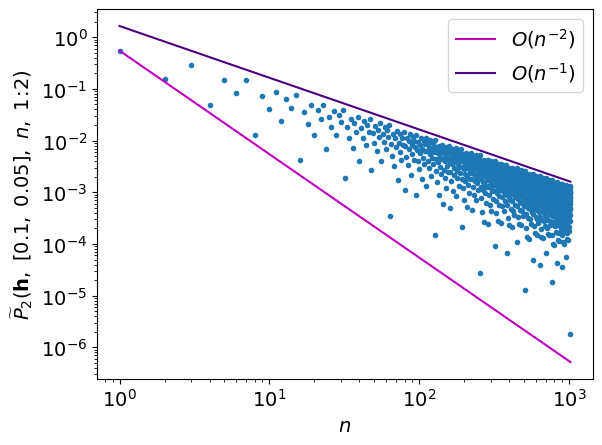

In [7]:

n_range = np.arange(1, 2**m_max+1)
plt.loglog(n_range, p_alpha_values, '.')


line = p_alpha_values[0] / n_range**2  
plt.loglog(n_range, line, 'm', label=r'$O(n^{-2})$') 

line1 = 3 * p_alpha_values[0] / n_range
plt.loglog(n_range, line1, 'indigo', label=r'$O(n^{-1})$') 

# line2 = 1 / np.sqrt(n_range)
# plt.loglog(n_range, line2, 'g', label=r'$n^{-1/2}$') 

plt.xlabel('$n$')
plt.ylabel(r'$\widetilde{P}_2(\mathbf{h},\ [0.1,\ 0.05],\ n,\ 1\!:\!2)$')
plt.legend()
# plt.ylabel(r'$P_2$')
plt.show()



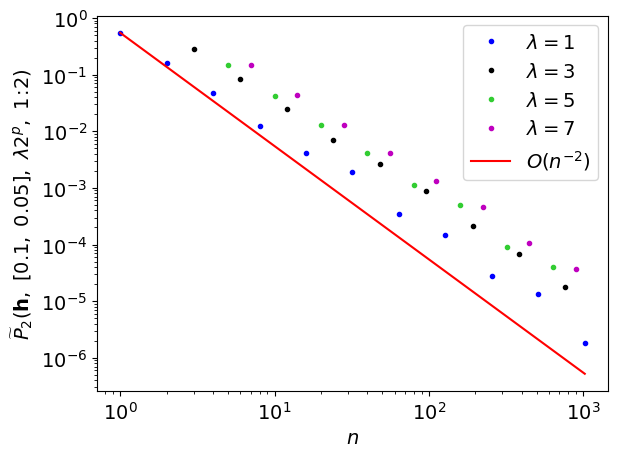

In [8]:
# sn.set_style("darkgrid", {"axes.facecolor": ".9"})
# p_alpha_values = p_alpha_n(sampler, m_max, gamma)
# n_vals = np.arange(1, 2**m_max)

# plt.loglog(n_vals, p_alpha_values, '.')


lambdas = [1, 3, 5, 7]
colors = ['b','k', 'limegreen', 'm'] 
for l, color in zip(lambdas, colors):
    vals_n = []
    p = 0
    while (n := l * (2**p)) <= 2**m_max:
        vals_n.append(n)
        p += 1
    vals_n = np.array(vals_n)
    plt.loglog(vals_n, p_alpha_values[vals_n - 1], '.', color=color, label=fr'$\lambda={l}$')


line = p_alpha_values[0] / n_range**2  
plt.loglog(n_range, line, 'r', label=r'$O(n^{-2})$') 

# line1 = p_alpha_values[0] / n_range
# plt.loglog(n_range, line1, 'indigo', label=r'$O(n^{-1})$') 


plt.xlabel('$n$')
plt.ylabel(r'$\widetilde{P}_2(\mathbf{h},\ [0.1,\ 0.05],\ \lambda 2^p,\ 1\!:\!2)$')
plt.legend()
#plt.title(r' $P_\alpha(n)$')
plt.tight_layout()
plt.show()

In [17]:
vals_n

array([  7,  14,  28,  56, 112, 224, 448, 896])

In [ ]:
# P_4 ?
# B_4 = x^4 - 2x^3 + x^2 - 1/30

In [108]:
def GramMat(x=None, coordwts=None):
    if x is None:
        x = np.array([[0, 0], [0.5, 0.5], [0.25, 0.25]])
    if coordwts is None:
        coordwts = (np.arange(1, 51, dtype=float))**-2  
    
    n, d = x.shape
    coordwts = coordwts[:d]  
    
    xmat = np.mod(x[:, np.newaxis, :] - x[np.newaxis, :, :], 1)
    K = np.prod(1 + 0.5 * coordwts[np.newaxis, np.newaxis, :] * (xmat * (xmat - 1) + 1/6), axis=2)
    
    return K


K = GramMat()
print(K)


[[1.10590278 0.94835069 0.98700629]
 [0.94835069 1.10590278 0.98700629]
 [0.98700629 0.98700629 1.10590278]]


In [109]:
def discrepancy(n=2**8, d=2, coordwts=(np.arange(1, 51, dtype=float)) ** -2):
    
    optfwtsall = np.zeros((n, n))
    ssdiscopt = np.zeros(n)
    ssdisc = np.zeros(n)
    
    xlat = qp.Lattice(d).gen_samples(n)
    kernellat = GramMat(xlat, coordwts)
    
    for m in range(1, n + 1):
        K = kernellat[:m, :m]
         
        preoptfwts = inv(K) @ np.ones((m, 1))

        optfwts = preoptfwts / (np.ones((1, m)) @ preoptfwts)
        optfwtsall[:m, m - 1] = optfwts.flatten()
        
        ssdiscopt[m - 1] = 1 - 2 * np.sum(optfwts) + optfwts.T @ K @ optfwts
        ssdisc[m - 1] = -1 + np.ones((1, m)) @ K @ np.ones((m, 1)) / m**2
    
    return ssdiscopt, ssdisc, xlat, optfwtsall

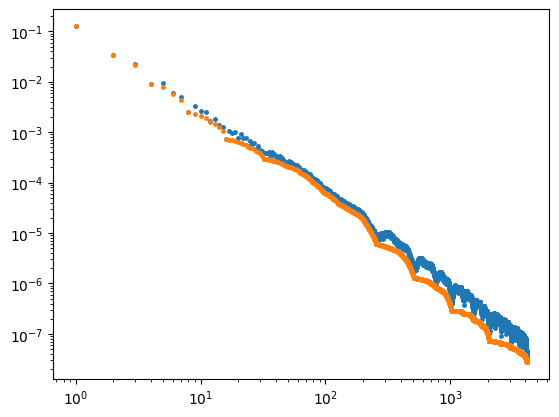

In [9]:
n = 2**12
d = 6

coordwts = (np.arange(1, 51, dtype=float)) ** -2
ssdiscopt, ssdisc, xlat, optfwts = discrepancy(n,d,coordwts)

plt.figure()
plt.loglog(np.arange(1, n + 1), ssdisc, '.', markersize=5, label = 'equal weights')
plt.loglog(np.arange(1, n + 1), ssdiscopt, '.', markersize=5, label = 'unequal weights')
plt.show()

In [10]:
import pickle

disc_data = {
    'ssdiscopt': ssdiscopt,
    'ssdisc': ssdisc,
    'xlat': xlat,
    'optfwts': optfwts
}

with open('discrepancy_data.pkl', 'wb') as f:
    pickle.dump(disc_data , f)

In [97]:
with open('discrepancy_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

ssdiscopt = loaded_data['ssdiscopt']
ssdisc = loaded_data['ssdisc']
xlat = loaded_data['xlat']
optfwts = loaded_data['optfwts']

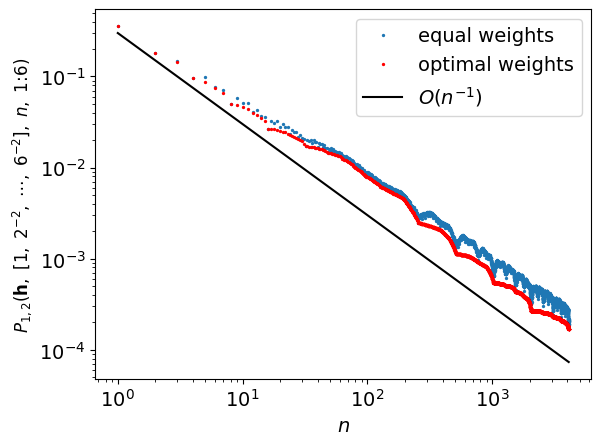

In [196]:
n = 2**12
plt.figure()
plt.loglog(np.arange(1, n + 1), np.sqrt(ssdisc), '.', markersize=2.75, label = 'equal weights')
plt.loglog(np.arange(1, n + 1), np.sqrt(ssdiscopt), '.', markersize=2.75, color = 'r',label = 'optimal weights')

line = 0.3/np.arange(1, n + 1)
plt.loglog(np.arange(1, n + 1), line,label=r'$O(n^{-1})$',color='k')
plt.xlabel(r'$n$')
plt.ylabel(r'$P_{1,2}(\mathbf{h}, \ [1, \ 2^{-2}, \ \cdots, \ 6^{-2}], \ n, \ 1\!:\!6)$',fontsize=12)
plt.legend()
plt.show()

In [57]:
ssdiscopt.shape

(4096,)

In [66]:
def compute_ratios(n, d, coordwts,start,end):
    
    ssdiscopt, ssdisc, _, _ = discrepancy(n, d, coordwts)

    if start == 2**6:
        x_values = list(range(2**6, 2**7))
    else:
        x_values = list(range(2**6+1,2**7+1))
    #x_values = list(range(2**6, 2**7 + 1))  
    ratios_ssdisc = []
    ratios_ssdiscopt = []
    for n in x_values:
        if end < 2**7:
            ratio_ssdisc = ssdisc[n] / ssdisc[2**6]  
            ratio_ssdiscopt = ssdiscopt[n]/ ssdiscopt[2**6]
        else:
            ratio_ssdisc = ssdisc[n] / ssdisc[2**7]  
            ratio_ssdiscopt = ssdiscopt[n]/ ssdiscopt[2**7]

        ratios_ssdisc.append(ratio_ssdisc)
        ratios_ssdiscopt.append(ratio_ssdiscopt)

    return x_values, ratios_ssdisc, ratios_ssdiscopt

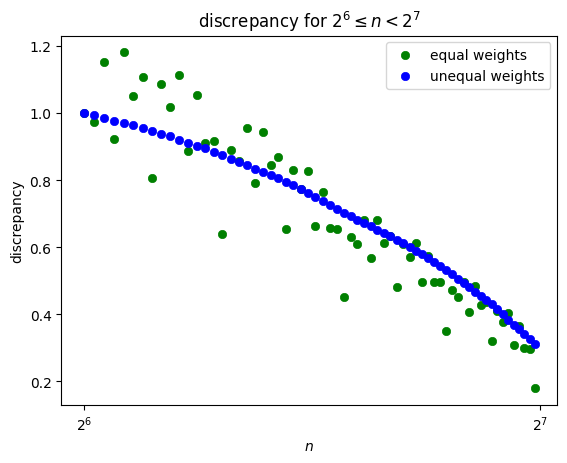

In [42]:
n = 2**7
d = 2 
coordwts = (np.arange(1, 51, dtype=float)) ** -2

#ssdiscopt, ssdisc, xlat, optfwts = discrepancy(n,d,coordwts)

x_vals, ratios_eq_w, ratios_uneq_w  = compute_ratios(n, d, coordwts,2**6,2**7-1)
plt.scatter(x_vals, ratios_eq_w, color='g', label='equal weights',linewidth=0.5)
plt.scatter(x_vals, ratios_uneq_w, color='b', label='unequal weights',linewidth=0.5)
plt.xscale('log', base=2)
plt.title(r'discrepancy for $2^6 \leq n < 2^7$')
plt.xlabel(r'$n$')
plt.ylabel('discrepancy')  
plt.legend()
plt.show()

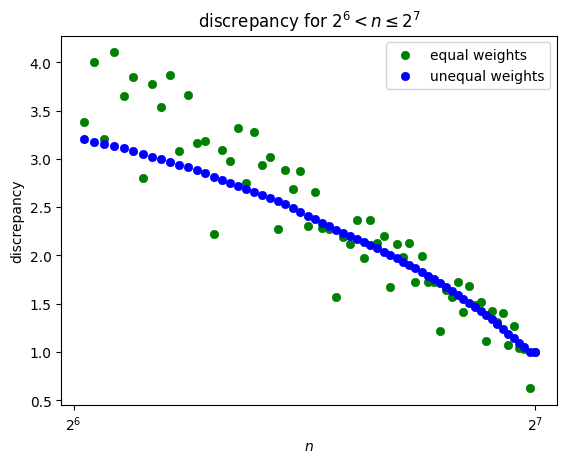

In [67]:
n = 2**8
d = 2 
coordwts = (np.arange(1, 51, dtype=float)) ** -2
x_vals, ratios_eq_w, ratios_uneq_w  = compute_ratios(n, d, coordwts,2**6+1,2**7)
plt.scatter(x_vals, ratios_eq_w, color='g', label='equal weights',linewidth=0.5)
plt.scatter(x_vals, ratios_uneq_w, color='b', label='unequal weights',linewidth=0.5)
plt.xscale('log', base=2)
plt.title(r'discrepancy for $2^6 < n \leq 2^7$')
plt.xlabel(r'$n$')
plt.ylabel('discrepancy')  
plt.legend()
plt.show()

In [182]:
n = 2**7
d = 2
coordwts = (np.arange(1, 51, dtype=float)) ** -2
ssdiscopt_n, ssdisc_n, _, _ = discrepancy(n,d,coordwts)

n_vec = np.arange(1,n+1)
n_floor = (2**np.floor(np.log2(n_vec))).astype(int)

print(n_vec)
print(n_floor)
print(ssdiscopt_n.shape)

ratio_eq = ssdisc_n/ssdisc_n[n_floor-1]
ratio_uneq = ssdiscopt_n/ssdiscopt_n[n_floor-1]


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128]
[  1   2   2   4   4   4   4   8   8   8   8   8   8   8   8  16  16  16
  16  16  16  16  16  16  16  16  16  16  16  16  16  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64 

In [38]:
ssdiscopt_n

array([1.05902778e-01, 2.71267361e-02, 1.70042293e-02, 7.06651476e-03,
       6.01385090e-03, 4.35698431e-03, 3.35794760e-03, 1.78443061e-03,
       1.66674128e-03, 1.53477431e-03, 1.35158788e-03, 1.13452310e-03,
       1.01096529e-03, 8.82229082e-04, 6.89709114e-04, 4.77737851e-04,
       4.64224640e-04, 4.49069803e-04, 4.34652253e-04, 4.18465949e-04,
       3.94311250e-04, 3.69287957e-04, 3.41320384e-04, 3.12185117e-04,
       2.97658755e-04, 2.82680620e-04, 2.68286552e-04, 2.53444515e-04,
       2.28186701e-04, 2.02751612e-04, 1.75547625e-04, 1.48114231e-04,
       1.45666930e-04, 1.42537806e-04, 1.39586437e-04, 1.35777750e-04,
       1.32368110e-04, 1.28539778e-04, 1.24354822e-04, 1.19603589e-04,
       1.15606941e-04, 1.11419474e-04, 1.07310632e-04, 1.03004783e-04,
       9.76729058e-05, 9.21347299e-05, 8.65343619e-05, 8.07137517e-05,
       7.83483549e-05, 7.60424557e-05, 7.35805401e-05, 7.11795806e-05,
       6.85834915e-05, 6.60522927e-05, 6.33443249e-05, 6.07028563e-05,
      

In [39]:
ssdisc_n[n_floor-1]

array([1.05902778e-01, 2.71267361e-02, 2.71267361e-02, 7.06651476e-03,
       7.06651476e-03, 7.06651476e-03, 7.06651476e-03, 1.78443061e-03,
       1.78443061e-03, 1.78443061e-03, 1.78443061e-03, 1.78443061e-03,
       1.78443061e-03, 1.78443061e-03, 1.78443061e-03, 4.77737851e-04,
       4.77737851e-04, 4.77737851e-04, 4.77737851e-04, 4.77737851e-04,
       4.77737851e-04, 4.77737851e-04, 4.77737851e-04, 4.77737851e-04,
       4.77737851e-04, 4.77737851e-04, 4.77737851e-04, 4.77737851e-04,
       4.77737851e-04, 4.77737851e-04, 4.77737851e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
       1.48114231e-04, 1.48114231e-04, 1.48114231e-04, 1.48114231e-04,
      

In [40]:
ratio_uneq 

array([1.        , 1.        , 0.62684391, 1.        , 0.85103493,
       0.61656764, 0.47519148, 1.        , 0.93404656, 0.8600919 ,
       0.7574337 , 0.63578998, 0.56654783, 0.49440369, 0.38651495,
       1.        , 0.97171417, 0.93999209, 0.9098133 , 0.87593216,
       0.82537159, 0.77299288, 0.71445121, 0.65346532, 0.62305877,
       0.59170656, 0.56157692, 0.5305096 , 0.47763999, 0.4243993 ,
       0.36745597, 1.        , 0.98347694, 0.96235051, 0.94242421,
       0.91670969, 0.89368935, 0.86784219, 0.83958726, 0.8075091 ,
       0.78052555, 0.75225367, 0.72451264, 0.6954415 , 0.65944309,
       0.62205184, 0.5842407 , 0.54494258, 0.5289725 , 0.51340412,
       0.49678238, 0.48057219, 0.46304458, 0.44595507, 0.42767211,
       0.40983811, 0.38744882, 0.36540367, 0.34295873, 0.32085875,
       0.29561373, 0.27071165, 0.2453084 , 1.        , 0.99395692,
       0.98810506, 0.97989286, 0.97173614, 0.96490487, 0.95834394,
       0.949029  , 0.93984743, 0.93213398, 0.92450061, 0.91537

In [41]:
ratio_eq

array([1.        , 1.        , 0.66533333, 1.        , 1.08107486,
       0.65099168, 0.55321399, 1.        , 1.43105481, 1.09942043,
       1.09694745, 0.67798892, 0.79210108, 0.57250473, 0.53030562,
       1.        , 1.61078747, 1.41608238, 1.5499575 , 1.11008539,
       1.34916435, 1.09443045, 1.0810171 , 0.69060294, 0.92726752,
       0.80632047, 0.84778318, 0.60557496, 0.71100525, 0.56101734,
       0.54038152, 1.        , 1.56400316, 1.45758962, 1.64347969,
       1.26861602, 1.559101  , 1.33467235, 1.35873725, 0.9428666 ,
       1.24820843, 1.12838146, 1.20562806, 0.91452603, 1.07222601,
       0.88590153, 0.87116003, 0.55416322, 0.79832424, 0.74373426,
       0.82599372, 0.64351272, 0.78003784, 0.66693035, 0.67600872,
       0.46162582, 0.6149878 , 0.55026959, 0.58909316, 0.43131511,
       0.51444629, 0.41060084, 0.40034252, 1.        , 1.72626983,
       1.68146545, 1.98902133, 1.59309113, 2.03869074, 1.81213127,
       1.90953375, 1.39003848, 1.87593861, 1.75699007, 1.92337

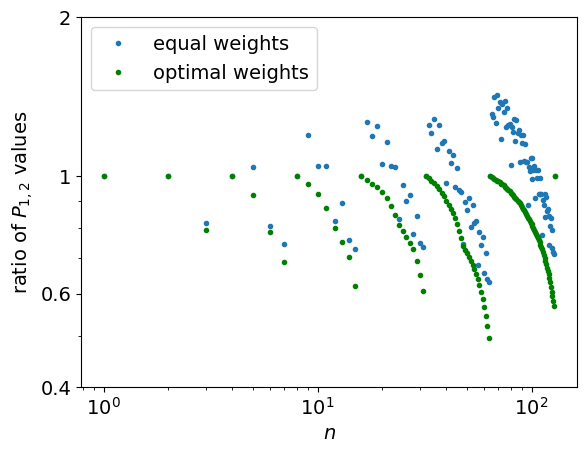

In [188]:
plt.loglog(n_vec, np.sqrt(ratio_eq), '.', linestyle='none',label='equal weights')
plt.loglog(n_vec, np.sqrt(ratio_uneq), '.', linestyle='none',color='g',label='optimal weights')
plt.xlabel('$n$')
plt.ylabel('ratio of $P_{1,2}$ values')
#plt.ylabel(r'$P_{1,2}^2(\mathbf{h}, \ [1, \ 2^{-2}, \ \cdots, \ 6^{-2}, \ n, \ 1\!:\!6])$')
plt.ylim(0.4,2)
plt.yticks([0.4, 0.6, 1, 2], [0.4, 0.6, 1, 2])
plt.xticks()
#plt.title(r'P$_\alpha(n)$/P$_\alpha$($\lfloor log_b(n) \rfloor$)')
plt.legend(loc='upper left')
plt.show()

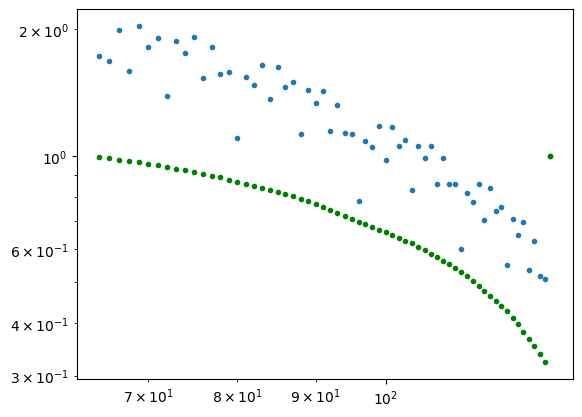

In [222]:
plt.loglog(n_vec[2**6:], ratio_eq[2**6:], '.', linestyle='none')
plt.loglog(n_vec[2**6:], ratio_uneq[2**6:], '.', linestyle='none',color='g')

In [189]:
# n = 2**7
# ssdiscopt_n, ssdisc_n, _, _ = discrepancy(n,d,coordwts)

# ratio_eq = ssdisc_n/ssdisc_m[-1] 
# ratio_uneq = ssdiscopt_n/ssdiscopt_m[-1]

# n_vec = np.arange(1,n+1)
n_ceil = (2**np.ceil(np.log2(n_vec))).astype(int)
#n_floor = n_floor.astype(int)
print(n_vec)
print(n_ceil)
# print(n_floor)
# print(ssdiscopt_n.shape)

ratio_eq = ssdisc_n/ssdisc_n[n_ceil-1]
ratio_uneq = ssdiscopt_n/ssdiscopt_n[n_ceil-1]

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128]
[  1   2   4   4   8   8   8   8  16  16  16  16  16  16  16  16  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 

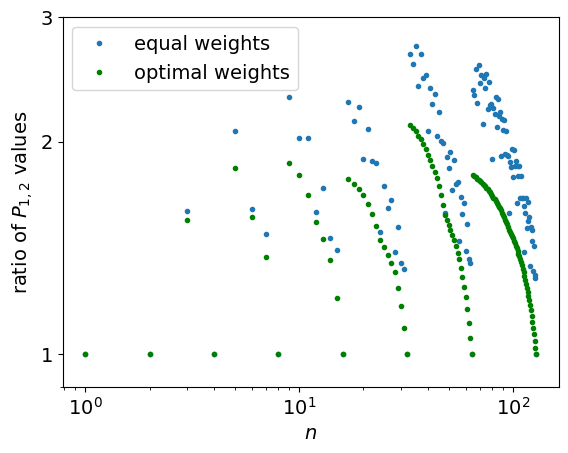

In [195]:
plt.loglog(n_vec, np.sqrt(ratio_eq), '.', linestyle='none', label='equal weights')
plt.loglog(n_vec, np.sqrt(ratio_uneq), '.', linestyle='none',color='g', label='optimal weights')
#plt.title(r'P$_\alpha(n)$/P$_\alpha$($ \lceil log_b(n) \rceil$)')
plt.ylabel('ratio of $P_{1,2}$ values')
plt.xlabel('$n$')
plt.ylim(0.9,3)
plt.yticks([1, 2, 3], [1, 2, 3])
#plt.ylabel(r'$P_{\alpha,2}^2$')
plt.legend()
plt.show()

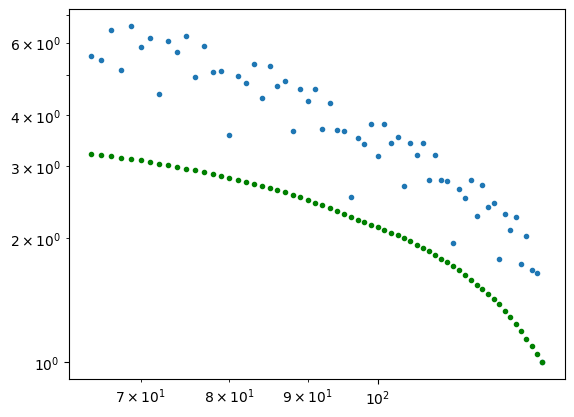

In [216]:
plt.loglog(n_vec[2**6:], ratio_eq[2**6:], '.', linestyle='none')
plt.loglog(n_vec[2**6:], ratio_uneq[2**6:], '.', linestyle='none',color='g')


In [35]:
k = qp.Keister(qp.Lattice(2,seed=7))
x = k.discrete_distrib.gen_samples(2**10)
x = x[:-1]
y = k.f(x)
y.mean()
# accumulative mean /sum 

1.810368537624551

In [36]:
k = qp.Keister(qp.Lattice(2,seed=7))
x = k.discrete_distrib.gen_samples(2**10)
y = k.f(x)
y.mean()

1.8092690523425161